In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Check Path

In [0]:

from pathlib import Path
p = Path('/content/drive/My Drive/')
images = list(p.glob('boostnet_labeldata/data/training/*.jpg'))
len(images)

490

# **Install PyTorch**

In [0]:
!pip3 uninstall pytorch -y
!pip3 uninstall pytorch-nightly -y
!pip3 uninstall torch -y
!pip3 uninstall torchvision -y

Uninstalling torch-1.1.0:
  Successfully uninstalled torch-1.1.0
Uninstalling torchvision-0.3.0:
  Successfully uninstalled torchvision-0.3.0


In [0]:
!pip install -c pytorch pytorch-nightly torchvision cudatoolkit=10.0
!pip install torchvision==0.2.2

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 61kB 34.3MB/s 
     |████████████████████████████████| 748.9MB 21kB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


#Import torch

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import csv

device = 'cuda:0' 

# Train BoostNet

In [0]:
# BoostNet Dataset
# from SpineWeb dataset16
# link: http://spineweb.digitalimaginggroup.ca/spineweb/index.php?n=Main.Datasets

class BoostNetDataset(torch.utils.data.Dataset):
    def __init__(self, path, train=True):
        self.images = []
        self.labels = []
        
        if train:
            image_path = path + "/data/training/"
            names = csv.reader(open(path + "/labels/training/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/training/landmarks.csv", 'r'))
        else:
            image_path = path + "/data/test/"
            names = csv.reader(open(path + "/labels/test/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/test/landmarks.csv", 'r'))
        
        for landmark_each_image in landmarks:
            coordinate_list = []
            for coordinate in landmark_each_image:
                coordinate_list.append(float(coordinate))
            self.labels.append(torch.Tensor(coordinate_list))

        for i, name in enumerate(names):
            origin_image = cv.imread(image_path + name[0], cv.IMREAD_GRAYSCALE)
            
            target_height = 512
            target_width = 256
            image = np.zeros((target_height, target_width), np.uint8)
            cv.resize(origin_image, (target_width, target_height), image)
            
            image = np.reshape(image, (1, image.shape[0], image.shape[1]))
            image_tensor = torch.from_numpy(image).float()
            
            self.images.append(image_tensor)

        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.images)
    
            

In [0]:
# initialize the train and test data loader

train_data = BoostNetDataset("/content/drive/My Drive/boostnet_labeldata", train=True)
test_data = BoostNetDataset("/content/drive/My Drive/boostnet_labeldata", train=False)

batch = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                         shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch,
                                         shuffle=True, num_workers=2)


print("number of batches(training): ", len(train_loader))
print("number of batches(testing): ",len(test_loader))

number of batches(training):  121
number of batches(testing):  32


#Define ConvNet

In [0]:
# define network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, 1, 1)
        self.conv2 = nn.Conv2d(4, 8, 3, 1, 1)
        self.conv3 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv4 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv5 = nn.Conv2d(32, 32, 3, 1, 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32 * 16 * 8, 512)
        self.fc2 = nn.Linear(512, 136)
        
    def forward(self, x):        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        x = x.view(-1, 32 * 16 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
#net = ConvNet()
#net = torch.load('/disk1/jklu/models/shallow.pth')
net = torch.load('drive/My Drive/boostnet_labeldata/models/conv-shallow.pth')

net = net.to(device)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torc

In [0]:
# define loss function

import torch.optim as optim

criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)

#lr_func = lambda epoch: epoch * 1
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.99)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

In [0]:
# function to compute loss

def compute_loss(net, data_loader):
    loss_sum = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs.float(), labels.float()) 
            loss_sum += loss.item()
            
    return loss_sum / len(data_loader)

#Train

In [0]:
# training

epoch_num = 100

loss1 = []
loss2 = []

for epoch in range(epoch_num):  # loop over the dataset multiple times
   
    for i, data in enumerate(train_loader, 0):
                
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()
        
    scheduler.step()    
    
    train_loss = compute_loss(net, train_loader)
    loss1.append(train_loss)

    test_loss = compute_loss(net, test_loader)
    loss2.append(test_loss)
    print("epoch number", epoch+1, "train_loss", train_loss, "test_loss", test_loss)

print('Finished Training')

epoch number 1 train_loss 0.006079018935715118 test_loss 0.00458923980477266
epoch number 2 train_loss 0.0047981571098250795 test_loss 0.004148046169575537
epoch number 3 train_loss 0.00447305783625569 test_loss 0.004270796984201297
epoch number 4 train_loss 0.002896402703698201 test_loss 0.002980211629619589
epoch number 5 train_loss 0.0023505197220274115 test_loss 0.0026644496028893627
epoch number 6 train_loss 0.0021049623009133005 test_loss 0.0030312579801829997
epoch number 7 train_loss 0.0022231698294039354 test_loss 0.003663990857603494
epoch number 8 train_loss 0.001952757267088991 test_loss 0.0025418915884074522
epoch number 9 train_loss 0.001642164467325942 test_loss 0.002513380084565142
epoch number 10 train_loss 0.001567836057621801 test_loss 0.002869566809749813
epoch number 11 train_loss 0.001608160126681078 test_loss 0.0027942797205469105
epoch number 12 train_loss 0.00154204460193811 test_loss 0.0031040418944030534
epoch number 13 train_loss 0.002060903534524081 test_lo

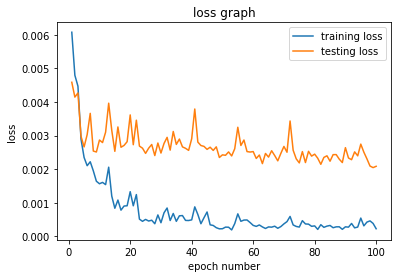

In [0]:
x = range(1, epoch_num+1)

plt.plot(x, loss1, label="training loss")
plt.plot(x, loss2, label="testing loss")
plt.xlabel("epoch number")
#plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("loss")
plt.title("loss graph")
plt.legend()
#plt.savefig("./coordinate-regression-loss.jpg")
plt.show()

In [0]:
torch.save(net, 'drive/My Drive/boostnet_labeldata/models/conv-shallow.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
def CVimshow2pltimshow(cv_img):
    """
    cv_img: [3, height, width], BGR, numpy array, int(0-255)
    """
    b,g,r = cv.split(cv_img)  
    plt_img = cv.merge([r,g,b]).astype(np.int)
    return plt_img

tensor([[0.4383, 0.5620, 0.4446, 0.5629, 0.4491, 0.5620, 0.4544, 0.5543, 0.4522,
         0.5486, 0.4431, 0.5326, 0.4318, 0.5289, 0.4118, 0.4949, 0.4049, 0.4807,
         0.3698, 0.4470, 0.3487, 0.4259, 0.3193, 0.4100, 0.3130, 0.3996, 0.2951,
         0.4005, 0.3124, 0.3924, 0.3111, 0.3997, 0.3235, 0.4071, 0.3331, 0.4320,
         0.3597, 0.4435, 0.3828, 0.4824, 0.4100, 0.5037, 0.4357, 0.5404, 0.4567,
         0.5659, 0.4786, 0.5837, 0.4937, 0.6023, 0.5160, 0.6265, 0.5092, 0.6316,
         0.5108, 0.6261, 0.5094, 0.6161, 0.4891, 0.5924, 0.4602, 0.5856, 0.4368,
         0.5636, 0.4176, 0.5474, 0.3911, 0.5247, 0.0592, 0.0505, 0.0885, 0.0832,
         0.0972, 0.0947, 0.1255, 0.1282, 0.1359, 0.1395, 0.1609, 0.1704, 0.1746,
         0.1831, 0.1939, 0.2052, 0.2070, 0.2221, 0.2358, 0.2513, 0.2467, 0.2604,
         0.2821, 0.2900, 0.2914, 0.3024, 0.3288, 0.3328, 0.3442, 0.3421, 0.3804,
         0.3721, 0.3928, 0.3828, 0.4322, 0.4172, 0.4456, 0.4287, 0.4854, 0.4626,
         0.4952, 0.4748, 0.5

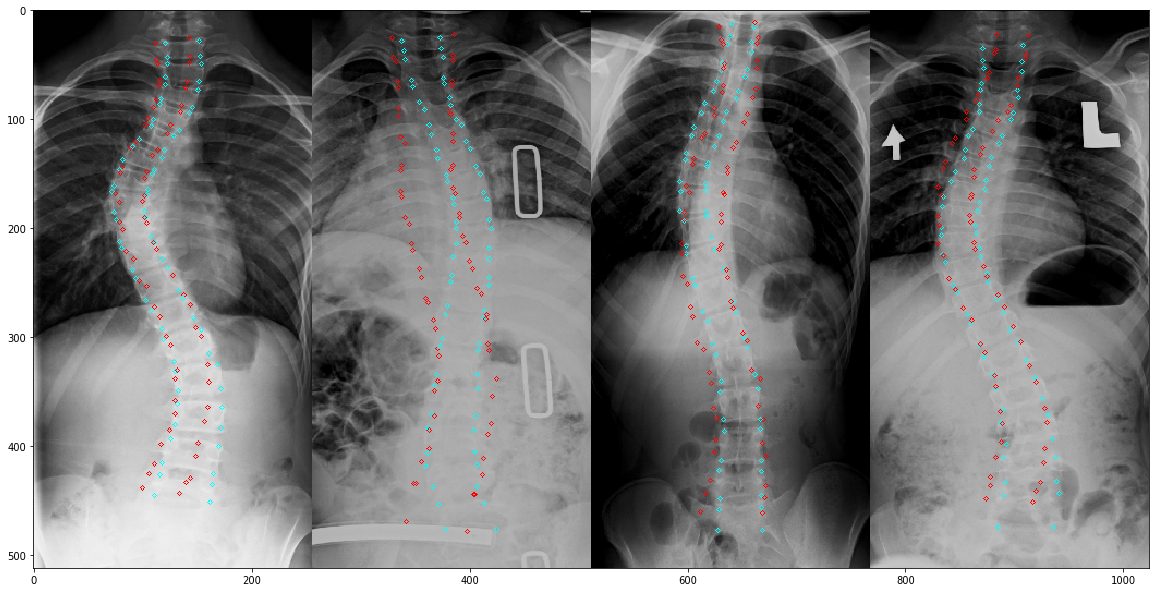

In [0]:
# visualize result
# note: opencv will take image as BGR but plt.imshow will take as RGB. 
# plt.show need int for 0-255 scale or float for 0-1 scale at each pixel

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

dataiter = iter(test_loader)
images, labels = dataiter.next()
batch, channel, height, width = images.shape
# note: images.shape = (batch, channel, width, height)

ret = net(images.to(device))

print(ret)

batch_img = np.zeros((height, width * batch, 3), np.int)

for i in range(batch):
    sample = images[i].numpy().squeeze(0)
    sample_BGR = cv.cvtColor(sample, cv.COLOR_GRAY2BGR)

    label = labels[i]
    predict = ret[i]

    point_num = len(label) // 2
    for j in range(point_num):
        cv.circle(sample_BGR, (int(label[j] * width), int(label[j + point_num]* height)), 2, (255, 255, 0))
        cv.circle(sample_BGR, (int(predict[j] * width), int(predict[j + point_num]* height)), 2, (0, 0, 255))
        
    plt_img = CVimshow2pltimshow(sample_BGR)
    batch_img[:, i * width:(i+1) * width, :] = plt_img
    
    
plt.imshow(batch_img)


# Predict Sample Images


In [0]:
net = torch.load('drive/My Drive/boostnet_labeldata/models/conv-shallow.pth')

net = net.to(device)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torc

In [0]:
import cv2
class BoostNetChallgeDataset(torch.utils.data.Dataset):
    def __init__(self, names, transform=None):
        self.images = []
        self.labels = []
          
        for i, path in enumerate(names):
            #origin_image = cv.imread(str(name), cv.IMREAD_GRAYSCALE)
            image_name = path.name
            self.labels.append(image_name)
            origin_image = cv2.imread(str(path),0)
            target_height = 512
            target_width = 256
            image = np.zeros((target_height, target_width), np.uint8)
            cv.resize(origin_image, (target_width, target_height), image)
            
            image = np.reshape(image, (1, image.shape[0], image.shape[1]))
            image_tensor = torch.from_numpy(image).float()
            
            self.images.append(image_tensor)
 
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label
    
    def __len__(self):
        return len(self.images)
      
      
      

In [0]:
# zero the parameter gradients
#optimizer.zero_grad()
from pathlib import Path
p = Path('.')
test_images = list(p.glob('drive/My Drive/boostnet_labeldata/test/*.jpg'))
len(test_images)

98

In [0]:
target_data = BoostNetChallgeDataset(test_images)
  
batch = 4
target_loader = torch.utils.data.DataLoader(target_data, batch_size=batch,
                                         shuffle=True, num_workers=2)

print("number of batches(testing): ",len(target_loader))
 

number of batches(testing):  25


In [0]:
def CVimshow2pltimshow(cv_img):
    """
    cv_img: [3, height, width], BGR, numpy array, int(0-255)
    """
    b,g,r = cv.split(cv_img)  
    plt_img = cv.merge([r,g,b]).astype(np.int)
    return plt_img

('01-July-2019-94.jpg', '01-July-2019-28.jpg', '01-July-2019-42.jpg', '01-July-2019-30.jpg')


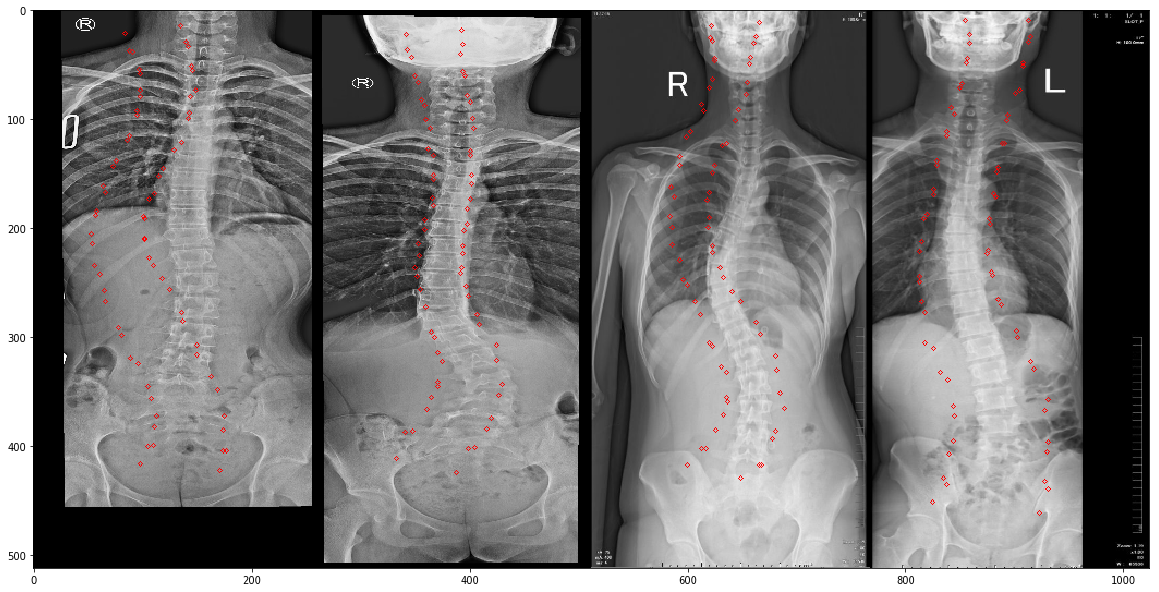

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

dataiter = iter(target_loader)
images,labels = dataiter.next()
batch, channel, height, width = images.shape
# note: images.shape = (batch, channel, width, height)

#image names
print(labels)
ret = net(images.to(device))

batch_img = np.zeros((height, width * batch, 3), np.int)

for i in range(batch):
    sample = images[i].numpy().squeeze(0)
    sample_BGR = cv.cvtColor(sample, cv.COLOR_GRAY2BGR)

    predict = ret[i]

    point_num = len(predict) // 2
    for j in range(point_num):
      cv.circle(sample_BGR, (int(predict[j] * width), int(predict[j + point_num]* height)), 2, (0, 0, 255))
        
    plt_img = CVimshow2pltimshow(sample_BGR)
    batch_img[:, i * width:(i+1) * width, :] = plt_img
    
    
plt.imshow(batch_img)


#Export the result to CSV file

In [0]:
for path in test_images:
  image_name = path.name
  origin_image = cv2.imread(str(path),0)
  target_height = 512
  target_width = 256
  image = np.zeros((target_height, target_width), np.uint8)
  cv.resize(origin_image, (target_width, target_height), image)
  dest = "drive/My Drive/boostnet_labeldata/test/resized/" + image_name
  print(dest)
  print(image.shape)
  cv2.imwrite(dest, image)

drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-87.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-93.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-84.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-44.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-51.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-50.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-78.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-53.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-90.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-92.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-45.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-86.jpg
(512, 256)
drive/My Drive/boostnet_labeldata/test/resized/01-July-2019-79.j

In [0]:
#dataiter = iter(target_loader)
land_pred = np.empty([98, 136])
image_names = []
  
index = 0
for images, labels in target_loader:
  batch, channel, height, width = images.shape
  ret = net(images.to(device))
  for i in range(batch):
    predict = ret[i]
    lineIndex = index + i;
    image_names.append(labels[i])
    #print(image_names)
    point_num = len(predict)
    #print("copy data for line : " + str(lineIndex+ 1))
    for j in range(point_num):
      land_pred[lineIndex,j]= predict[j]
      
  index+=4

In [0]:
len(image_names)

98

In [0]:
import numpy
numpy.savetxt("drive/My Drive/boostnet_labeldata/test/landmarks.csv", land_pred, delimiter=",", fmt="%1.5f")

In [0]:
import csv

with open("drive/My Drive/boostnet_labeldata/test/filenames.csv",'w',newline='') as f:
    wr = csv.writer(f)
    for name in image_names:
      wr.writerow([name,])

#Read Landmarks and Convert to MAT files

In [0]:
import csv
import numpy as np
import mat4py
land_array = []
images=[]
p2 = []
width = 256
height = 512
mat_out = 'drive/My Drive/boostnet_labeldata/test/matfiles'

In [0]:
images= []
names = csv.reader(open('drive/My Drive/boostnet_labeldata/test/filenames.csv', 'r'))
for i, land in enumerate(names):
       images.append(land)

 

In [0]:
landmarks = csv.reader(open('drive/My Drive/boostnet_labeldata/test/landmarks.csv', 'r'))
for i, land in enumerate(landmarks):
       land_array.append(land)
len(land_array)

In [0]:
for i, name in enumerate(images):
    point_num = len(land_array[i]) // 2
    predict = land_array[i]
    points = np.empty((point_num,2))
    for j in range(point_num):
        left = int(float(predict[j]) * width)
        right = int(float(predict[j + point_num])* height)
        points[j] = [left,right]
                    
    data = {'p2' : points.tolist()}
    filename = mat_out +"/"+ name[0] +".mat"
    mat4py.savemat(filename, data)